<a href="https://colab.research.google.com/github/Cheol-Kyu/Recommending_Books/blob/main/book_rec)svdpp%2Bcatboost.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install catboost
!pip install scikit-surprise

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 772.0/772.0 kB 6.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.3-cp310-cp310-linux_x86_64.whl size=3095453 sha256=7b0467ee85525028bb8607af38a96ce9bf22040317623ac196bc725166ead1e5
  Stored in directory: /root/.cache/pip/wheels/a5/ca/a8/4e28def53797fdc4363ca4af740db15a9c2f1595ebc51fb445
Successfully built scikit-surprise


In [ ]:
import re
import os
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from catboost import CatBoostRegressor, Pool
from gensim.models.word2vec import Word2Vec
from surprise import Reader, Dataset, SVD, SVDpp, accuracy
from surprise.model_selection import KFold, cross_validate, GridSearchCV
from surprise.dataset import DatasetAutoFolds
from tqdm import tqdm

In [ ]:
seed = 42
deterministic = True

os.environ["PYTHONHASHSEED"] = str(seed)
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
if deterministic:
	torch.backends.cudnn.deterministic = True
	torch.backends.cudnn.benchmark = False

In [ ]:
PATH = '/content/drive/MyDrive/Pywork/rec_books'

In [ ]:
df = pd.read_csv(PATH+'/train.csv')
df.head(3)

,ID,User-ID,Book-ID,Book-Rating,Age,Location,Book-Title,Book-Author,Year-Of-Publication,Publisher
0,TRAIN_000000,USER_00000,BOOK_044368,8,23.0,"sackville, new brunswick, canada",Road Taken,Rona Jaffe,2001.0,Mira
1,TRAIN_000001,USER_00000,BOOK_081205,8,23.0,"sackville, new brunswick, canada",Macbeth (New Penguin Shakespeare),William Shakespeare,1981.0,Penguin Books
2,TRAIN_000002,USER_00000,BOOK_086781,0,23.0,"sackville, new brunswick, canada",Waverley (Penguin English Library),Walter Scott,1981.0,Penguin Books


## 전처리

In [ ]:
# preprocessing location
replaced_loc = {
    'spain': ['españa', 'catalunya spain'],
    'united states': ['united sates', 'usa (currently living in england)', 'los estados unidos de norte america', 'u.s.a.', 'us', 'united state',
                      'disgruntled states of america', 'u.s. of a.', 'u.s>', 'america', 'usa'],
    'u.a.e': ['united arab emirates'],
    'u.k.': ['united kindgonm', 'united kingdom', 'wales', 'england','scotland', 'uk'],
    'italia': ['l`italia'],
    'unknown': ['petrolwar nation', 'the world tomorrow', 'la chine éternelle!', 'la chine éternelle !', 'n/a', 'polk', 'pender',
                'we`re global!', 'n/a - on the road', 'the great white north', 'rutherford', 'here and there', 'k1c7b1', 'quit',
                'everywhere and anywhere', 'far away...', 'ee.uu', '']
}

z = df['Location'].apply(lambda x: x.split(','))

# 공백 제거
s = []
for l in z:
  ss = []
  for i in l:
    i = i.strip()
    ss.append(i)
  s.append(ss)

# 지역명 전처리
for i in range(len(s)):
  for nation in replaced_loc.keys():
    for name in replaced_loc[nation]:
      if s[i][-1] == name:
        s[i][-1] = name
        break

df['Location'] = s

In [ ]:
loc_vector = Word2Vec(sentences=s, vector_size=5, window=2, epochs=50, min_count=1, workers=1, seed=42)

def location_vectorizer(address:list) -> list:
  result = []
  for i in tqdm(range(len(address))):
    loc_vector.random.seed(42)
    _ = loc_vector.wv[address[i]].mean(axis=0)
    result.append(list(_))
  return result

s_ = location_vectorizer(s)
df['Location'] = s_

100%|██████████| 871393/871393 [00:24<00:00, 35941.39it/s]


In [ ]:
# 나이 전처리
df['Age'] = df['Age'].apply(lambda x: 8 if x <= 8 else x)
df['Age'] = df['Age'].apply(lambda x: 80 if x >= 80 else x)

In [ ]:
# 출판년도 전처리
m = df['Year-Of-Publication'].median()
df['Year-Of-Publication'] = df['Year-Of-Publication'].apply(lambda x: m if x==-1 else x)

In [ ]:
df_x = df[['User-ID',	'Book-ID', 'Age',	'Location',	'Book-Author',	'Year-Of-Publication',	'Publisher']].copy()
df_y = df[['Book-Rating']].copy()
train_x, val_x, train_y, val_y = train_test_split(df_x, df_y, test_size=0.2, random_state=42)

cat_features = ['User-ID',	'Book-ID',	'Book-Author', 'Publisher']
embedding_features = ['Location']
train_data = Pool(data=train_x, label=train_y, cat_features=cat_features, embedding_features=embedding_features)
val_data = Pool(data=val_x, label=val_y, cat_features=cat_features, embedding_features=embedding_features)

In [ ]:
pd.concat([train_x[['User-ID','Book-ID']], train_y], axis=1).to_csv('train.csv', index=False, header=False)
pd.concat([val_x[['User-ID','Book-ID']], val_y], axis=1).to_csv('validate.csv', index=False, header=False)

In [ ]:
col = 'user item rating'
reader = Reader(line_format=col, sep=',', rating_scale=(0,10))
trainset = Dataset.load_from_file('train.csv', reader=reader)
valset = Dataset.load_from_file('validate.csv', reader=reader)

## 모델 학습

In [ ]:
algo = SVDpp(n_factors=2, n_epochs=5, random_state=42, cache_ratings=True)
algo.fit(trainset.build_full_trainset())

In [ ]:
def predict_point(dataframe:pd.DataFrame, func=algo) -> pd.DataFrame:
  num = len(dataframe)
  preds = []
  for i in range(num):
    user, item = dataframe.iloc[i,:]
    pred = func.predict(user, item, verbose=True).est
    preds.append(pred)
  return preds

In [ ]:
model = CatBoostRegressor(iterations=1000, loss_function='RMSE', random_seed=42, verbose=100, task_type="GPU", devices='0:1')
model.fit(train_data)

Learning rate set to 0.095233
0:	learn: 3.7835103	total: 36.9ms	remaining: 36.8s
100:	learn: 3.3449597	total: 3.44s	remaining: 30.6s
200:	learn: 3.3320590	total: 6.69s	remaining: 26.6s
300:	learn: 3.3250992	total: 9.87s	remaining: 22.9s
400:	learn: 3.3205944	total: 13.2s	remaining: 19.7s
500:	learn: 3.3163215	total: 16.3s	remaining: 16.2s
600:	learn: 3.3125260	total: 19.3s	remaining: 12.8s
700:	learn: 3.3096712	total: 22.3s	remaining: 9.53s
800:	learn: 3.3066067	total: 26.1s	remaining: 6.48s
900:	learn: 3.3039879	total: 29.7s	remaining: 3.27s
999:	learn: 3.3015416	total: 32.8s	remaining: 0us


In [ ]:
pd.DataFrame(model.get_feature_importance(), index=df_x.columns)

,0
User-ID,68.257444
Book-ID,1.429044
Age,3.324248
Location,7.135464
Book-Author,9.342724
Year-Of-Publication,3.936030
Publisher,6.575046


In [ ]:
from sklearn.metrics import mean_squared_error
preds = model.predict(val_data)
mean_squared_error(val_y, preds, squared=False)

3.272080143655931

In [ ]:
preds_ = predict_point(val_x[['User-ID','Book-ID']], func=algo)

In [ ]:
chart = pd.DataFrame([list(preds), preds_, val_y.values.reshape(-1,)], index=['cat_pred','svd_pred','answer']).T

### 모델 앙상블

In [ ]:
import math

def ensemble(df:pd.DataFrame, weight:float) -> list:
  ensembled_preds = []
  for i in range(len(chart)):
    a, b = chart.iloc[i,0], chart.iloc[i,1]
    _ = a*weight+b*(1-weight)
    ensembled_preds.append(_)
  return ensembled_preds

100%|██████████| 20/20.0 [01:59<00:00,  5.95s/it]


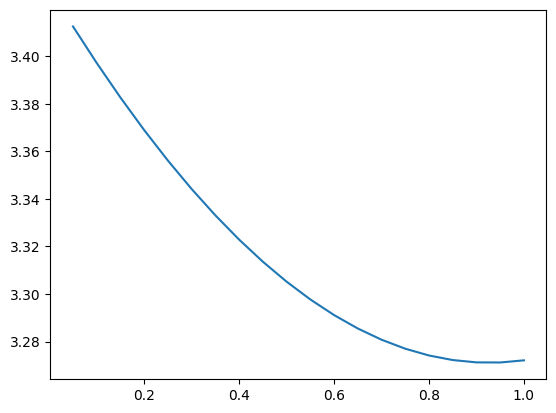

In [ ]:
history = pd.DataFrame(columns=['weight','RMSE'])

with tqdm(total=1/0.05)as pbar:
  weight = 1.0
  while weight > 0:
    pbar.update(1)
    predicted = ensemble(chart, weight)
    rmse = mean_squared_error(val_y, predicted, squared=False)
    history = pd.concat([history,pd.DataFrame([weight,rmse], index=['weight','RMSE']).T], axis=0)
    weight -= 0.05

plt.plot(history['weight'],history['RMSE'])

In [ ]:
history

,weight,RMSE
0,1.00,3.272080
0,0.95,3.271182
0,0.90,3.271222
0,0.85,3.272202
0,0.80,3.274119
0,0.75,3.276972
0,0.70,3.280759
0,0.65,3.285477
0,0.60,3.291122
0,0.55,3.297688


In [ ]:
mean_squared_error(val_y, ensembled_preds, squared=False)

3.2722016904962037

In [ ]:
pd.DataFrame([list(preds), preds_, ensembled_preds, val_y.values.reshape(-1,)], index=['cat_pred','svd_pred','ensembled_preds','answer']).T

,cat_pred,svd_pred,ensembled_preds,answer
0,1.599772,0.875906,1.491192,0.0
1,5.666283,1.897553,5.100974,0.0
2,3.162167,3.276351,3.179294,10.0
3,-0.238313,0.251383,-0.164858,0.0
4,4.737076,3.410492,4.538089,6.0
...,...,...,...,...
174274,1.388401,1.300822,1.375264,0.0
174275,1.800874,1.672397,1.781602,0.0
174276,3.621347,3.586380,3.616102,6.0
174277,2.773304,3.244578,2.843995,0.0


## 추론

In [ ]:
testdf = pd.read_csv(PATH+'/test.csv', encoding='UTF-8')

In [ ]:
z = testdf['Location'].apply(lambda x: x.split(','))

# 공백 제거
s = []
for l in z:
  ss = []
  for i in l:
    i = i.strip()
    ss.append(i)
  s.append(ss)

# 지역명 전처리
for i in range(len(s)):
  for j in range(len(s[i])):
    if s[i][j] in loc_vector.wv.key_to_index.keys():
      pass
    else:
      s[i][j] = 'unknown'

for i in range(len(s)):
  for nation in replaced_loc.keys():
    for name in replaced_loc[nation]:
      if s[i][-1] == name:
        s[i][-1] = name
        break

testdf['Location'] = location_vectorizer(s)

100%|██████████| 159621/159621 [00:04<00:00, 34482.63it/s]


In [ ]:
# 나이 전처리
testdf['Age'] = testdf['Age'].apply(lambda x: 8 if x <= 8 else x)
testdf['Age'] = testdf['Age'].apply(lambda x: 80 if x >= 80 else x)

In [ ]:
# 출판년도 전처리
testdf['Year-Of-Publication'] = testdf['Year-Of-Publication'].apply(lambda x: m if x==-1 else x)

In [ ]:
testdf = testdf[['User-ID',	'Book-ID', 'Age',	'Location',	'Book-Author',	'Year-Of-Publication',	'Publisher']].copy()
cat_features = ['User-ID',	'Book-ID',	'Book-Author', 'Publisher']
embedding_features = ['Location']

test_data = Pool(data=testdf, cat_features=cat_features, embedding_features=embedding_features)

In [ ]:
preds1 = model.predict(test_data)
preds2 = predict_point(testdf[['User-ID','Book-ID']], func=algo)

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
user: USER_88956 item: BOOK_096617 r_ui = None   est = 1.37   {'was_impossible': False}
user: USER_88956 item: BOOK_097903 r_ui = None   est = 1.41   {'was_impossible': False}
user: USER_88956 item: BOOK_098958 r_ui = None   est = 1.41   {'was_impossible': False}
user: USER_88956 item: BOOK_099680 r_ui = None   est = 1.18   {'was_impossible': False}
user: USER_88956 item: BOOK_100475 r_ui = None   est = 1.41   {'was_impossible': False}
user: USER_88956 item: BOOK_100813 r_ui = None   est = 1.67   {'was_impossible': False}
user: USER_88956 item: BOOK_102097 r_ui = None   est = 1.42   {'was_impossible': False}
user: USER_88956 item: BOOK_104581 r_ui = None   est = 1.58   {'was_impossible': False}
user: USER_88956 item: BOOK_105113 r_ui = None   est = 1.34   {'was_impossible': False}
user: USER_88956 item: BOOK_105506 r_ui = None   est = 1.03   {'was_impossible': False}
user: USER_88956 item: BOOK_105922 r_ui = None   est = 1.41   {'was_impossible': Fal

In [ ]:
def ensembled_preds(pred1:list, pred2:list, weight:float) -> list:
  if len(pred1)==len(pred2):
    ensembled_preds = []
    weight=weight
    for i in tqdm(range(len(pred1))):
      a, b = pred1[i], pred2[i]
      _ = a*weight+b*(1-weight)
      ensembled_preds.append(_)
    return ensembled_preds

  else:
    raise ValueError

In [ ]:
predsf = ensembled_preds(preds1, preds2, 0.9)

100%|██████████| 159621/159621 [00:00<00:00, 1287040.19it/s]


In [ ]:
sam = pd.read_csv(PATH+'/sample_submission.csv', encoding='UTF-8')
sam['Book-Rating'] = predsf
sam.to_csv(PATH+'/ensemble(catboost9+svdpp1).csv', encoding='UTF-8', index=False)